In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

# Standard library imports
import argparse
import csv
import math
import os
import pickle
import random
import re
import sys
import csv
from collections import Counter
import dice_ml



# Append config directory to sys.path
script_dir = os.path.dirname(os.path.abspath("/home/ubuntu/dds_paper/DDS_Paper/code"))  # Absolute dir the script is in
sys.path.append(os.path.join(script_dir, '..', 'config'))

# Third-party library imports
import joblib
import ltn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from rich.console import Console
from rich.table import Table
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tqdm import tqdm
from numpy import mean
import time

# Local module imports
from model_creation import LSTMModel, lr_schedule
from sequence_generation import load_sequences, save_sequences
from model_evaluation import kfold_cross_validation, normalize_importances, permutation_importance_per_class
from pgb_data_processing import overview_csv_files, process_pgb_data
from data_scaling import load_and_scale_data
from util import concatenate_and_delete_ltn_csv_files
import commons as commons
from tensorflow.keras.callbacks import Callback

import numpy as np
import tensorflow as tf
from alibi.explainers import Counterfactual
from omnixai.data.timeseries import Timeseries
from omnixai.explainers.timeseries import TimeseriesExplainer


import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt

ltn_model_path = ""

# Load the model weights and data
model_path = '/home/ubuntu/dds_paper/DDS_Paper/model_weights/model_PGB_30_0_fold_1.h5'
ltn_model_path = '/home/ubuntu/dds_paper/DDS_Paper/model_weights/ltn_tf_model_PGB_30_0_fold_1.tf'
sequences_path = '/home/ubuntu/dds_paper/DDS_Paper/data/DDS_Data_SEU/data/csvs/sequences/PGB_30_0_test_scaled_sequences.npy'
labels_path = '/home/ubuntu/dds_paper/DDS_Paper/data/DDS_Data_SEU/data/csvs/sequences/PGB_30_0_test_scaled_labels.npy'

sequences, labels = load_sequences(sequences_path, labels_path)


input_shape = (sequences.shape[1], sequences.shape[2])  # Adjust input shape from the loaded data

num_classes = len(np.unique(labels))

if ltn_model_path != "":
    model = tf.keras.models.load_model(ltn_model_path)
    importances_path = os.path.join("/home/ubuntu/dds_paper/DDS_Paper/model_weights/normalized_importances_PGB_30_0_fold_1.csv")
    normalized_average_importances = np.loadtxt(importances_path, delimiter=',', skiprows=1)

    sequences = sequences * np.array(normalized_average_importances)
else:
    model = LSTMModel(input_shape=input_shape, num_classes=num_classes, reg_type="l1", reg_value=0.001, return_logits=True)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    model.build(input_shape=(None, *input_shape))  # None is for batch size
    model.load_weights(model_path)

# Step 1: Make original predictions using the model
original_predictions_logits = model.predict(sequences, verbose=0)
original_predicted_classes = np.argmax(original_predictions_logits, axis=-1)

# Adjust these variables as needed
max_attempts = 500       # Maximum number of perturbation attempts per timestep
perturbation_step = 0.001 # The amount by which to increase the perturbation

# Initialize a dictionary to store perturbation results
perturbation_results_limited = {}
num_sequences_to_analyze = 1  # Analyze the first sequence

for seq_index in range(num_sequences_to_analyze):
    original_sequence = sequences[seq_index].copy()
    original_class = original_predicted_classes[seq_index]
    perturbation_results_limited[seq_index] = []
    
    # Iterate over each timestep in the sequence
    for time_index in range(sequences.shape[1]):
        perturbation_magnitude_pos = 0
        perturbation_magnitude_neg = 0
        positive_flip_found = False
        negative_flip_found = False
        positive_result = None
        negative_result = None
        attempts_pos = 0
        attempts_neg = 0

        # Check for positive perturbation
        while attempts_pos < max_attempts and not positive_flip_found:
            attempts_pos += 1
            perturbation_magnitude_pos += perturbation_step
            
            # Positive perturbation
            perturbed_sequence_pos = original_sequence.copy()
            perturbed_sequence_pos[time_index] += perturbation_magnitude_pos
            
            perturbed_sequence_expanded_pos = np.expand_dims(perturbed_sequence_pos, axis=0)
            perturbed_prediction_logits_pos = model.predict(perturbed_sequence_expanded_pos, verbose=0)
            perturbed_class_pos = np.argmax(perturbed_prediction_logits_pos, axis=-1)[0]
            
            if perturbed_class_pos != original_class:
                positive_result = {
                    'time_index': time_index,
                    'original_class': original_class,
                    'perturbed_class': perturbed_class_pos,
                    'perturbation': perturbation_magnitude_pos,
                    'attempts': attempts_pos,
                    'direction': '+'
                }
                positive_flip_found = True
                print(f"Sequence {seq_index}, Time Index {time_index}: Prediction flipped from {original_class} to {perturbed_class_pos} with positive perturbation {perturbation_magnitude_pos} after {attempts_pos} attempts.")
        
        # Check for negative perturbation
        while attempts_neg < max_attempts and not negative_flip_found:
            attempts_neg += 1
            perturbation_magnitude_neg += perturbation_step
            
            # Negative perturbation
            perturbed_sequence_neg = original_sequence.copy()
            perturbed_sequence_neg[time_index] -= perturbation_magnitude_neg
            
            perturbed_sequence_expanded_neg = np.expand_dims(perturbed_sequence_neg, axis=0)
            perturbed_prediction_logits_neg = model.predict(perturbed_sequence_expanded_neg, verbose=0)
            perturbed_class_neg = np.argmax(perturbed_prediction_logits_neg, axis=-1)[0]
            
            if perturbed_class_neg != original_class:
                negative_result = {
                    'time_index': time_index,
                    'original_class': original_class,
                    'perturbed_class': perturbed_class_neg,
                    'perturbation': -perturbation_magnitude_neg,
                    'attempts': attempts_neg,
                    'direction': '-'
                }
                negative_flip_found = True
                print(f"Sequence {seq_index}, Time Index {time_index}: Prediction flipped from {original_class} to {perturbed_class_neg} with negative perturbation {-perturbation_magnitude_neg} after {attempts_neg} attempts.")
        
        # Store results
        if positive_result:
            perturbation_results_limited[seq_index].append(positive_result)
        if negative_result:
            perturbation_results_limited[seq_index].append(negative_result)

# Create separate positive and negative perturbation matrices
positive_perturbation_matrix = np.full((num_sequences_to_analyze, 20), np.nan)
negative_perturbation_matrix = np.full((num_sequences_to_analyze, 20), np.nan)

# Fill matrices with positive and negative perturbations
for seq_index, flips in perturbation_results_limited.items():
    for flip in flips:
        time_idx = flip['time_index']
        perturbation = flip['perturbation']
        if flip['direction'] == '+':
            positive_perturbation_matrix[seq_index, time_idx] = perturbation
        elif flip['direction'] == '-':
            negative_perturbation_matrix[seq_index, time_idx] = perturbation

2024-09-23 15:05:03.010493: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-23 15:05:03.122737: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 15:05:03.122813: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 15:05:03.122926: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 15:05:03.153087: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-23 15:05:03.154633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Sequence 0, Time Index 0: Prediction flipped from 5 to 0 with positive perturbation 0.016000000000000007 after 16 attempts.
Sequence 0, Time Index 0: Prediction flipped from 5 to 8 with negative perturbation -0.16600000000000012 after 166 attempts.
Sequence 0, Time Index 1: Prediction flipped from 5 to 0 with positive perturbation 0.015000000000000006 after 15 attempts.
Sequence 0, Time Index 1: Prediction flipped from 5 to 8 with negative perturbation -0.17000000000000012 after 170 attempts.
Sequence 0, Time Index 2: Prediction flipped from 5 to 0 with positive perturbation 0.014000000000000005 after 14 attempts.
Sequence 0, Time Index 2: Prediction flipped from 5 to 8 with negative perturbation -0.18100000000000013 after 181 attempts.
Sequence 0, Time Index 3: Prediction flipped from 5 to 0 with positive perturbation 0.015000000000000006 after 15 attempts.
Sequence 0, Time Index 3: Prediction flipped from 5 to 8 with negative perturbation -0.20100000000000015 after 201 attempts.
Sequ

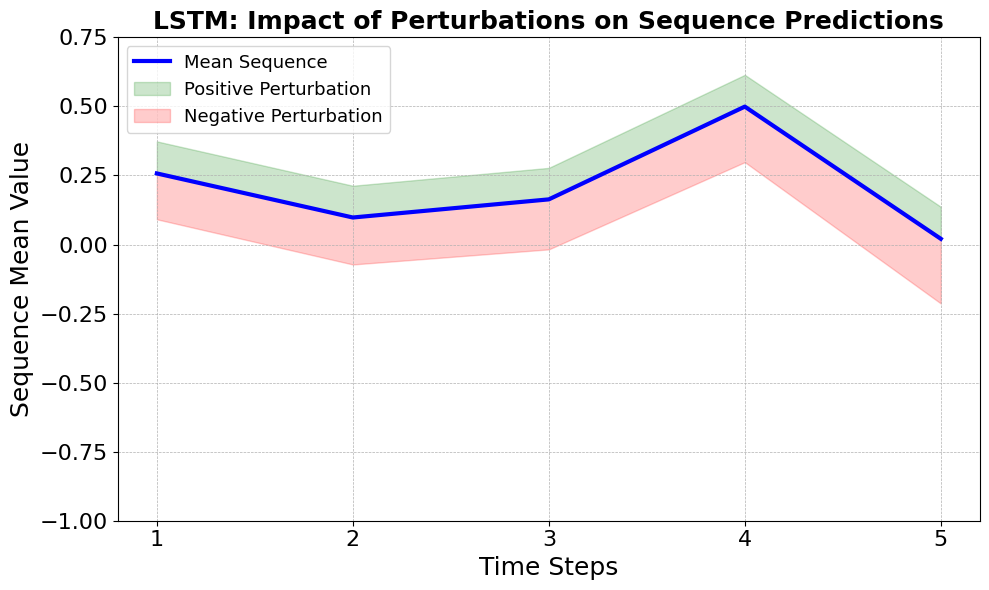

In [2]:
time_steps_to_plot =5
sequences_copy, labels_copy = load_sequences(sequences_path, labels_path)
# Determine the range for the X-axis (starting from 1 instead of 0)
x_ticks = np.arange(1, time_steps_to_plot + 1)

# Calculate the mean of the original sequence for the first 5 time steps (averaging across features)
mean_sequence = np.mean(sequences_copy[0, :time_steps_to_plot], axis=1)

# Retrieve the positive and negative perturbation values for the first 5 time steps
positive_perturbations = positive_perturbation_matrix[0, :time_steps_to_plot]
negative_perturbations = negative_perturbation_matrix[0, :time_steps_to_plot]

# Modify upper and lower bounds based on positive and negative perturbations
upper_bound = mean_sequence + np.nan_to_num(positive_perturbations + 0.1, nan=0)  # Adding positive perturbations
lower_bound = mean_sequence + np.nan_to_num(negative_perturbations, nan=0)  # Subtracting negative perturbations correctly

# Determine y-axis limits based on the data range with some margin
y_min = -1
y_max = 0.75

# Plot the mean sequence with separate positive and negative perturbations as error bounds
plt.figure(figsize=(10, 6))

# Plot the mean sequence (original sequence values) for the first 5 time steps
plt.plot(x_ticks, mean_sequence, label='Mean Sequence', linewidth=3, color='blue')

# Shaded area for positive perturbations
plt.fill_between(x_ticks, 
                 mean_sequence, 
                 upper_bound, 
                 color='green', alpha=0.2, label='Positive Perturbation')

# Shaded area for negative perturbations
plt.fill_between(x_ticks, 
                 lower_bound, 
                 mean_sequence,  # Reversed: lower_bound should be below mean_sequence
                 color='red', alpha=0.2, label='Negative Perturbation')

# Customize the x-ticks to display the first 5 time steps starting from 1
plt.xticks(ticks=x_ticks, labels=x_ticks, fontsize=16)

# Set appropriate y-axis limits based on the data
plt.ylim([y_min, y_max])

# Set y-ticks to be divisible by 0.25
plt.yticks(np.arange(y_min, y_max + 0.25, 0.25), fontsize=16)

# Set labels and title with larger fonts
plt.title('LSTM: Impact of Perturbations on Sequence Predictions', fontsize=18, fontweight='bold')
plt.xlabel('Time Steps', fontsize=18)
plt.ylabel('Sequence Mean Value', fontsize=18)

# Add a legend with larger font
plt.legend(loc = 'best', fontsize=13)

# Increase grid line width and font size for a clean journal-style presentation
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save the plot
plt.savefig("LSTM_CF.png", dpi=400)

# Display the plot
plt.show()


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

# Standard library imports
import argparse
import csv
import math
import os
import pickle
import random
import re
import sys
import csv
from collections import Counter
import dice_ml



# Append config directory to sys.path
script_dir = os.path.dirname(os.path.abspath("/home/ubuntu/dds_paper/DDS_Paper/code"))  # Absolute dir the script is in
sys.path.append(os.path.join(script_dir, '..', 'config'))

# Third-party library imports
import joblib
import ltn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from rich.console import Console
from rich.table import Table
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tqdm import tqdm
from numpy import mean
import time

# Local module imports
from model_creation import LSTMModel, lr_schedule
from sequence_generation import load_sequences, save_sequences
from model_evaluation import kfold_cross_validation, normalize_importances, permutation_importance_per_class
from pgb_data_processing import overview_csv_files, process_pgb_data
from data_scaling import load_and_scale_data
from util import concatenate_and_delete_ltn_csv_files
import commons as commons
from tensorflow.keras.callbacks import Callback

import numpy as np
import tensorflow as tf
from alibi.explainers import Counterfactual
from omnixai.data.timeseries import Timeseries
from omnixai.explainers.timeseries import TimeseriesExplainer


import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt

ltn_model_path = ""

# Load the model weights and data
model_path = '/home/ubuntu/dds_paper/DDS_Paper/model_weights/model_PGB_30_0_fold_1.h5'
#ltn_model_path = '/home/ubuntu/dds_paper/DDS_Paper/model_weights/ltn_tf_model_PGB_30_0_fold_1.tf'
sequences_path = '/home/ubuntu/dds_paper/DDS_Paper/data/DDS_Data_SEU/data/csvs/sequences/PGB_30_0_test_scaled_sequences.npy'
labels_path = '/home/ubuntu/dds_paper/DDS_Paper/data/DDS_Data_SEU/data/csvs/sequences/PGB_30_0_test_scaled_labels.npy'

sequences, labels = load_sequences(sequences_path, labels_path)

input_shape = (sequences.shape[1], sequences.shape[2])  # Adjust input shape from the loaded data

num_classes = len(np.unique(labels))

if ltn_model_path != "":
    model = tf.keras.models.load_model(ltn_model_path)
    importances_path = os.path.join("/home/ubuntu/dds_paper/DDS_Paper/model_weights/normalized_importances_PGB_30_0_fold_1.csv")
    normalized_average_importances = np.loadtxt(importances_path, delimiter=',', skiprows=1)

    sequences = sequences * np.array(normalized_average_importances)
else:
    model = LSTMModel(input_shape=input_shape, num_classes=num_classes, reg_type="l1", reg_value=0.001, return_logits=True)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    model.build(input_shape=(None, *input_shape))  # None is for batch size
    model.load_weights(model_path)

# Step 1: Make original predictions using the model
original_predictions_logits = model.predict(sequences, verbose=0)
original_predicted_classes = np.argmax(original_predictions_logits, axis=-1)

# Adjust these variables as needed
max_attempts = 500       # Maximum number of perturbation attempts per timestep
perturbation_step = 0.01 # The amount by which to increase the perturbation

# Initialize a dictionary to store perturbation results
perturbation_results_limited = {}
num_sequences_to_analyze = 1  # Analyze the first sequence

# Iterate over the first num_sequences_to_analyze sequences
# Iterate over the first num_sequences_to_analyze sequences
for seq_index in range(num_sequences_to_analyze):
    original_sequence = sequences[seq_index].copy()
    original_class = original_predicted_classes[seq_index]
    perturbation_results_limited[seq_index] = []
    
    # Iterate over each timestep in the sequence
# Iterate over the first 5 timesteps in the sequence
    for time_index in range(min(5, sequences.shape[1])):  # Ensure that the loop doesn't go beyond the number of available timesteps
        perturbation_magnitude_pos = 0
        perturbation_magnitude_neg = 0
        positive_flip_found = False
        negative_flip_found = False
        positive_result = None
        negative_result = None
        attempts_pos = 0
        attempts_neg = 0

        # Check for positive perturbation
        while attempts_pos < max_attempts and not positive_flip_found:
            attempts_pos += 1
            perturbation_magnitude_pos += perturbation_step

            # Positive perturbation
            perturbed_sequence_pos = original_sequence.copy()
            perturbed_sequence_pos[time_index] += perturbation_magnitude_pos

            perturbed_sequence_expanded_pos = np.expand_dims(perturbed_sequence_pos, axis=0)
            perturbed_prediction_logits_pos = model.predict(perturbed_sequence_expanded_pos, verbose=0)
            perturbed_class_pos = np.argmax(perturbed_prediction_logits_pos, axis=-1)[0]

            if perturbed_class_pos != original_class:
                positive_result = {
                    'time_index': time_index,
                    'original_class': original_class,
                    'perturbed_class': perturbed_class_pos,
                    'perturbation': perturbation_magnitude_pos,
                    'attempts': attempts_pos,
                    'direction': '+'
                }
                positive_flip_found = True
                print(f"Sequence {seq_index}, Time Index {time_index}: Prediction flipped from {original_class} to {perturbed_class_pos} with positive perturbation {perturbation_magnitude_pos} after {attempts_pos} attempts.")

        # Check for negative perturbation
        while attempts_neg < max_attempts and not negative_flip_found:
            attempts_neg += 1
            perturbation_magnitude_neg += perturbation_step

            # Negative perturbation
            perturbed_sequence_neg = original_sequence.copy()
            perturbed_sequence_neg[time_index] -= perturbation_magnitude_neg

            perturbed_sequence_expanded_neg = np.expand_dims(perturbed_sequence_neg, axis=0)
            perturbed_prediction_logits_neg = model.predict(perturbed_sequence_expanded_neg, verbose=0)
            perturbed_class_neg = np.argmax(perturbed_prediction_logits_neg, axis=-1)[0]

            if perturbed_class_neg != original_class:
                negative_result = {
                    'time_index': time_index,
                    'original_class': original_class,
                    'perturbed_class': perturbed_class_neg,
                    'perturbation': -perturbation_magnitude_neg,
                    'attempts': attempts_neg,
                    'direction': '-'
                }
                negative_flip_found = True
                print(f"Sequence {seq_index}, Time Index {time_index}: Prediction flipped from {original_class} to {perturbed_class_neg} with negative perturbation {-perturbation_magnitude_neg} after {attempts_neg} attempts.")

        # Store results
        if positive_result:
            perturbation_results_limited[seq_index].append(positive_result)
        if negative_result:
            perturbation_results_limited[seq_index].append(negative_result)


# Create separate positive and negative perturbation matrices
positive_perturbation_matrix = np.full((num_sequences_to_analyze, 5), np.nan)
negative_perturbation_matrix = np.full((num_sequences_to_analyze, 5), np.nan)

# Fill matrices with positive and negative perturbations
for seq_index, flips in perturbation_results_limited.items():
    for flip in flips:
        time_idx = flip['time_index']
        perturbation = flip['perturbation']
        if flip['direction'] == '+':
            positive_perturbation_matrix[seq_index, time_idx] = perturbation
        elif flip['direction'] == '-':
            negative_perturbation_matrix[seq_index, time_idx] = perturbation

Sequence 0, Time Index 0: Prediction flipped from 5 to 0 with positive perturbation 0.21000000000000005 after 21 attempts.
Sequence 0, Time Index 0: Prediction flipped from 5 to 8 with negative perturbation -0.7700000000000005 after 77 attempts.
Sequence 0, Time Index 1: Prediction flipped from 5 to 0 with positive perturbation 0.21000000000000005 after 21 attempts.
Sequence 0, Time Index 1: Prediction flipped from 5 to 8 with negative perturbation -0.7800000000000005 after 78 attempts.
Sequence 0, Time Index 2: Prediction flipped from 5 to 0 with positive perturbation 0.21000000000000005 after 21 attempts.
Sequence 0, Time Index 2: Prediction flipped from 5 to 8 with negative perturbation -0.8200000000000005 after 82 attempts.
Sequence 0, Time Index 3: Prediction flipped from 5 to 0 with positive perturbation 0.22000000000000006 after 22 attempts.
Sequence 0, Time Index 3: Prediction flipped from 5 to 8 with negative perturbation -0.8800000000000006 after 88 attempts.
Sequence 0, Time

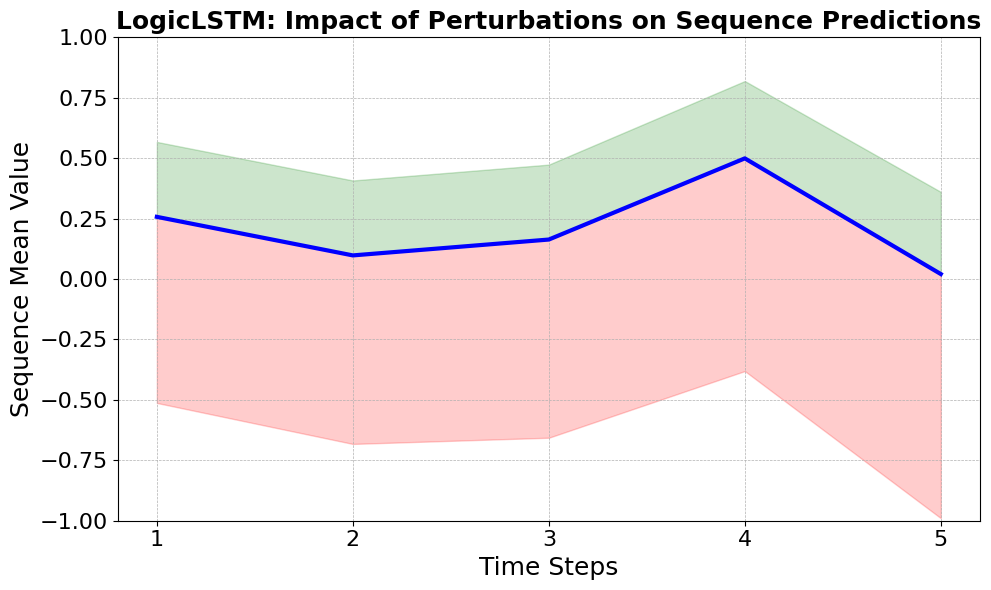

In [6]:
time_steps_to_plot =5
sequences_copy, labels_copy = load_sequences(sequences_path, labels_path)
# Determine the range for the X-axis (starting from 1 instead of 0)
x_ticks = np.arange(1, time_steps_to_plot + 1)

# Calculate the mean of the original sequence for the first 5 time steps (averaging across features)
mean_sequence = np.mean(sequences_copy[0, :time_steps_to_plot], axis=1)

# Retrieve the positive and negative perturbation values for the first 5 time steps
positive_perturbations = positive_perturbation_matrix[0, :time_steps_to_plot]
negative_perturbations = negative_perturbation_matrix[0, :time_steps_to_plot]

# Modify upper and lower bounds based on positive and negative perturbations
upper_bound = mean_sequence + np.nan_to_num(positive_perturbations + 0.1, nan=0)  # Adding positive perturbations
lower_bound = mean_sequence + np.nan_to_num(negative_perturbations, nan=0)  # Subtracting negative perturbations correctly

# Determine y-axis limits based on the data range with some margin
y_min = -1
y_max = 0.80

# Plot the mean sequence with separate positive and negative perturbations as error bounds
plt.figure(figsize=(10, 6))

# Plot the mean sequence (original sequence values) for the first 5 time steps
plt.plot(x_ticks, mean_sequence, label='Mean Sequence', linewidth=3, color='blue')

# Shaded area for positive perturbations
plt.fill_between(x_ticks, 
                 mean_sequence, 
                 upper_bound, 
                 color='green', alpha=0.2, label='Positive Perturbation')

# Shaded area for negative perturbations
plt.fill_between(x_ticks, 
                 lower_bound, 
                 mean_sequence,  # Reversed: lower_bound should be below mean_sequence
                 color='red', alpha=0.2, label='Negative Perturbation')

# Customize the x-ticks to display the first 5 time steps starting from 1
plt.xticks(ticks=x_ticks, labels=x_ticks, fontsize=16)

# Set appropriate y-axis limits based on the data
plt.ylim([y_min, y_max])

# Set y-ticks to be divisible by 0.25
plt.yticks(np.arange(y_min, y_max + 0.25, 0.25), fontsize=16)

# Set labels and title with larger fonts
plt.title('LogicLSTM: Impact of Perturbations on Sequence Predictions', fontsize=18, fontweight='bold')
plt.xlabel('Time Steps', fontsize=18)
plt.ylabel('Sequence Mean Value', fontsize=18)

# Add a legend with larger font
#plt.legend(loc = 'best', fontsize=13)

# Increase grid line width and font size for a clean journal-style presentation
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save the plot
plt.savefig("LTN_CF.png", dpi=400)

# Display the plot
plt.show()


In [5]:
# # Determine the range for the X-axis (starting from 1 instead of 0)
# x_ticks = np.arange(1, time_steps_to_plot + 1)

# # Calculate the mean of the original sequence for the first 5 time steps (averaging across features)
# mean_sequence = np.mean(sequences[0, :time_steps_to_plot], axis=1)

# # Retrieve the positive and negative perturbation values for the first 5 time steps
# positive_perturbations = positive_perturbation_matrix[0, :time_steps_to_plot]
# negative_perturbations = negative_perturbation_matrix[0, :time_steps_to_plot]

# # Modify upper and lower bounds based on positive and negative perturbations
# upper_bound = mean_sequence + np.nan_to_num(positive_perturbations, nan=0)  # Adding positive perturbations
# lower_bound = mean_sequence + np.nan_to_num(negative_perturbations, nan=0)  # Subtracting negative perturbations correctly

# # Determine y-axis limits dynamically based on the data range with some margin
# y_min = np.floor(np.min(lower_bound) / 0.25) * 0.25  # Rounding down to nearest multiple of 0.25
# y_max = np.ceil(np.max(upper_bound) / 0.25) * 0.25  # Rounding up to nearest multiple of 0.25

# # Plot the mean sequence with separate positive and negative perturbations as error bounds
# plt.figure(figsize=(10, 6))

# # Plot the mean sequence (original sequence values) for the first 5 time steps
# plt.plot(x_ticks, mean_sequence, label='Mean Sequence', linewidth=3, color='blue')

# # Shaded area for positive perturbations
# plt.fill_between(x_ticks, 
#                  mean_sequence, 
#                  upper_bound, 
#                  color='green', alpha=0.2, label='Positive Perturbation')

# # Shaded area for negative perturbations
# plt.fill_between(x_ticks, 
#                  lower_bound, 
#                  mean_sequence,  # Reversed: lower_bound should be below mean_sequence
#                  color='red', alpha=0.2, label='Negative Perturbation')

# # Customize the x-ticks to start from 1
# plt.xticks(ticks=x_ticks, labels=x_ticks, fontsize=16)

# # Set appropriate y-axis limits based on the data
# plt.ylim([y_min, y_max])

# # Set y-ticks to be divisible by 0.25
# plt.yticks(np.arange(y_min, y_max + 0.25, 0.25), fontsize=16)

# # Set labels and title with larger fonts
# plt.title('LogicLSTM: Impact of Perturbations on Sequence Predictions', fontsize=20, fontweight='bold')
# plt.xlabel('Time Steps', fontsize=18)
# plt.ylabel('Sequence Mean Value', fontsize=18)

# # Add a legend with larger font
# plt.legend(fontsize=13)

# # Increase grid line width and font size for a clean journal-style presentation
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.tight_layout()

# # Save the plot
# plt.savefig("LTN_CF.png", dpi=400)

# # Display the plot
# plt.show()
